# M01 First Foray

DS 5001 Text as Data

We take a raw text file from Project Gutenberg and convert it into a dataframe of tokens. 

We then explore some properties of the data. 

The main idea is to get acquainted with **the primary process of converting text into analytical form**.

## Set Up

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')

We define where the data live and go.

These are Kaggle's default folder names, but you can replicate these in your local environment.

In [2]:
data_home = '../input'
output_dir = '../working'

## Import File

We first grab a raw text file from Project Gutenberg. 

We grab the file locally, but you can get the plain text version from this page: [https://www.gutenberg.org/ebooks/105](https://www.gutenberg.org/ebooks/105)

In [3]:
src_file = f"{data_home}/gutenberg/pg105.txt"
lines = open(src_file, 'r').readlines()

Let's inspect the first and last five lines of the list of lines.

In [4]:
lines[:5]

['The Project Gutenberg EBook of Persuasion, by Jane Austen\n',
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n']

In [5]:
lines[-5:]

['\n',
 'This Web site includes information about Project Gutenberg-tm,\n',
 'including how to make donations to the Project Gutenberg Literary\n',
 'Archive Foundation, how to help produce our new eBooks, and how to\n',
 'subscribe to our email newsletter to hear about new eBooks.\n']

## Convert to Dataframe

Next, we convert these lines into a data frame.

We do this to take advantage of Pandas' vector-based functions, which allow us to process the text in a data scientific way.

In [6]:
text = pd.DataFrame(lines)

Let's look at a sample of lines:

In [7]:
text.sample(10)

,0
5815,\n
8437,paragraph 1.C below. There are a lot of thing...
5473,"long as she could, delighted to fancy she unde..."
1141,"being ""a fine girl."" She was now lying on the ..."
4576,"tolerable, by the effect which a man of decent..."
2236,"""Depend upon it, they were all perfectly comfo..."
4339,"and cold pies, where riotous boys were holding..."
848,"not a merely selfish caution, under which she ..."
956,\n
424,lose neither consequence nor enjoyment by sett...


Now let's give the column and index names.

In [8]:
text.columns = ['line_str']
text.index.name = 'line_num'

In [9]:
text.head()

,line_str
line_num,
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,\n
2,This eBook is for the use of anyone anywhere a...
3,almost no restrictions whatsoever. You may co...
4,re-use it under the terms of the Project Guten...


## Extract Simple Features

Now, let's extract some features from our content.

The most obvious one to grad is string length, i.e. the number of characters in the string.

In [10]:
text['len'] = text.line_str.str.len()

Here are some quick stats associated with this feature.

In [11]:
text.len.describe()

count    8734.000000
mean       55.673460
std        25.340378
min         1.000000
25%        61.000000
50%        68.000000
75%        71.000000
max        74.000000
Name: len, dtype: float64

Here is a histogram to show the distribution of line lengths.

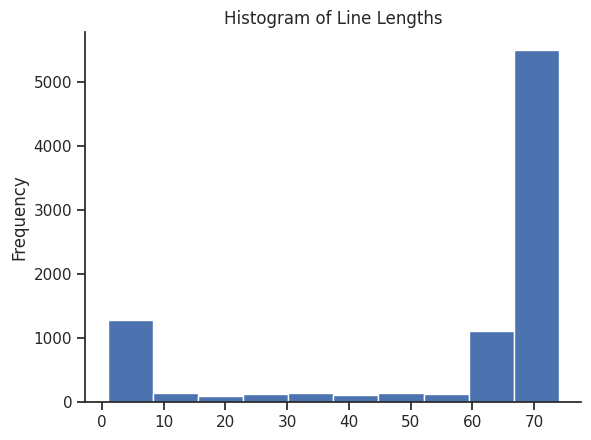

In [12]:
ax = text.len.plot.hist()
sns.despine()
plt.title("Histogram of Line Lengths")
plt.show()

And here is an annotated density plot to show the distribution as a model.

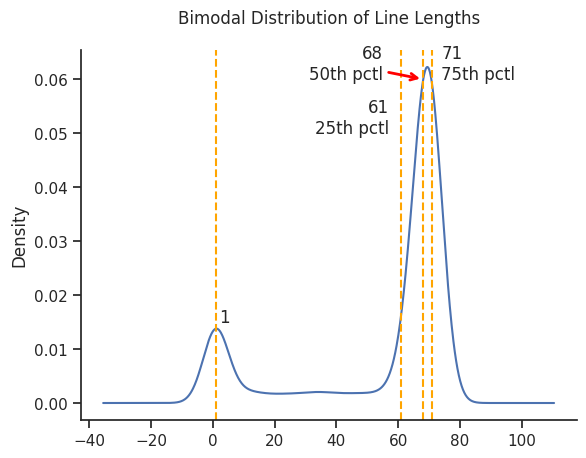

In [13]:
ax = text.len.plot.kde()

ax.axvline(1, c='orange', ls='--')
ax.annotate("1", xy=(2,.015), ha="left")

ax.axvline(61, c='orange', ls='--')
ax.annotate("61\n25th pctl", xy=(57,.05), ha="right")

ax.axvline(68, c='orange', ls='--')
ax.annotate("68\n50th pctl", xy=(68,.06), ha="right", 
    xytext=(55, .06),
    arrowprops=dict(
        arrowstyle="->",         # Arrow style (e.g., simple arrow)
        color='red',             # Arrow color
        lw=2                     # Line width
    )
)

ax.axvline(71, c='orange', ls='--')
ax.annotate("71\n75th pctl", xy=(74,.06), ha="left")

plt.title("Bimodal Distribution of Line Lengths", y=1.05)
sns.despine()
plt.show()

**Question: Why two humps?** 

Let's look at the first hump for characters.

In [14]:
text[text['len'] < 5].sample(10)

,line_str,len
line_num,,
3248,\n,1
5718,\n,1
8629,\n,1
5653,\n,1
6485,\n,1
4031,\n,1
3017,\n,1
4674,\n,1
8241,\n,1


**Interpretation:** The distribution reflects the structure of the text.

Extra line breaks signify paragraph breaks.

We can use this information to import the text as a series of paragraphs.

## Import Again

Now that we know what line breaks mean, we can use this information to import the file with a more accurate structure. 

Note also that we could have inferred this from visual inspection of the source file. 

But the principle is that **statistical features can provide evidence for structure**.

### Interpret line breaks `\n\n`

To read in the text as a series of paragraphs (or chunks), we use the double line break `\n\n` as the delimitter with which to split the text.

In [15]:
chunk_pat = '\n\n'
chunks = open(src_file, 'r').read().split(chunk_pat)

Let's see what we get.

In [16]:
chunks[:5]

['The Project Gutenberg EBook of Persuasion, by Jane Austen',
 'This eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.net',
 '\nTitle: Persuasion',
 'Author: Jane Austen',
 'Release Date: June 5, 2008 [EBook #105]\nLast Updated: February 15, 2015']

So, this looks good. Let's now create a new data frame of chunks.

In [17]:
text = pd.DataFrame(chunks, columns=['chunk_str'])
text.index.name = 'chunk_id'

In [18]:
text.shape

(1132, 1)

In [19]:
text.head()

,chunk_str
chunk_id,
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,This eBook is for the use of anyone anywhere a...
2,\nTitle: Persuasion
3,Author: Jane Austen
4,"Release Date: June 5, 2008 [EBook #105]\nLast ..."


### Remove remaining breaks

Now, let's do some cleaning up by removing single line breaks `\n` from the chunks.

In [20]:
text.chunk_str = text.chunk_str.str.replace('\n+', ' ', regex=True).str.strip()
text.head()

,chunk_str
chunk_id,
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,This eBook is for the use of anyone anywhere a...
2,Title: Persuasion
3,Author: Jane Austen
4,"Release Date: June 5, 2008 [EBook #105] Last U..."


## Convert Lines to Tokens

Next, we convert our chunks into tokens.

To do this, we use the `expand` argument to the `.split()` method.

Then we stack the results to create a data frame with a new feature and index.

In [21]:
TOKEN = text.chunk_str.str.split(expand=True).stack().to_frame('token_str')
TOKEN.index.names = ['chunk_num','token_num']

In [22]:
TOKEN

token_str
chunk_num token_num           
0         0                The
          1            Project
          2          Gutenberg
          3              EBook
          4                 of
...                        ...
1131      35                to
          36              hear
          37             about
          38               new
          39           eBooks.

[86307 rows x 1 columns]

Broken down into steps

In [23]:
# Effect of splitting
# text.chunk_str.str.split()

In [24]:
# Effect of expanding the split
# text.chunk_str.str.split(expand=True)

In [25]:
# Effect of stacking the result
# text.chunk_str.str.split(expand=True).stack()

In [26]:
# Effect of convert result from series to dataframe
# text.chunk_str.str.split(expand=True).stack().to_frame('token_str')

## Normalize the Tokens

At this point, we clean up the tokens by removing non-alphanumeric characters and lowercasing.

This is called **normalization**.

We are going to call a normalized token a **term**.

Note: there is more than one way to do this.

In [27]:
TOKEN['term_str'] = TOKEN.token_str.str.replace(r'\W+', '', regex=True).str.lower()

In [28]:
TOKEN.head(10)

token_str    term_str
chunk_num token_num                         
0         0                  The         the
          1              Project     project
          2            Gutenberg   gutenberg
          3                EBook       ebook
          4                   of          of
          5          Persuasion,  persuasion
          6                   by          by
          7                 Jane        jane
          8               Austen      austen
1         0                 This        this

## Extract a Vocabulary

Next, we extract the unique set of terms from the text.

These unique terms we will call **types**.

The result is a **vocabulary**, which is just a table of terms. 

So:

- **Terms** are word **types**.
- **Tokens** are word **instances**.

Note we are using the word "word" loosely here.

To do this, we use Pandas' `.value_counts()` method, which will give us the unique series of terms along with their counts.

In [29]:
VOCAB = TOKEN.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'

In [30]:
VOCAB.head(10)

,n
term_str,
the,3501
to,2862
and,2851
of,2684
a,1648
in,1439
was,1336
her,1202
had,1187


Next we compute relative frequency, an estimate of the probability of the word.

In [31]:
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()

In [32]:
VOCAB

,n,p
term_str,,
the,3501,0.040564
to,2862,0.033161
and,2851,0.033033
of,2684,0.031098
a,1648,0.019095
...,...,...
shared,1,0.000012
uniform,1,0.000012
50,1,0.000012


## Visualize Frequent Words

Now that we have a vocabulary, we can explore its properties.

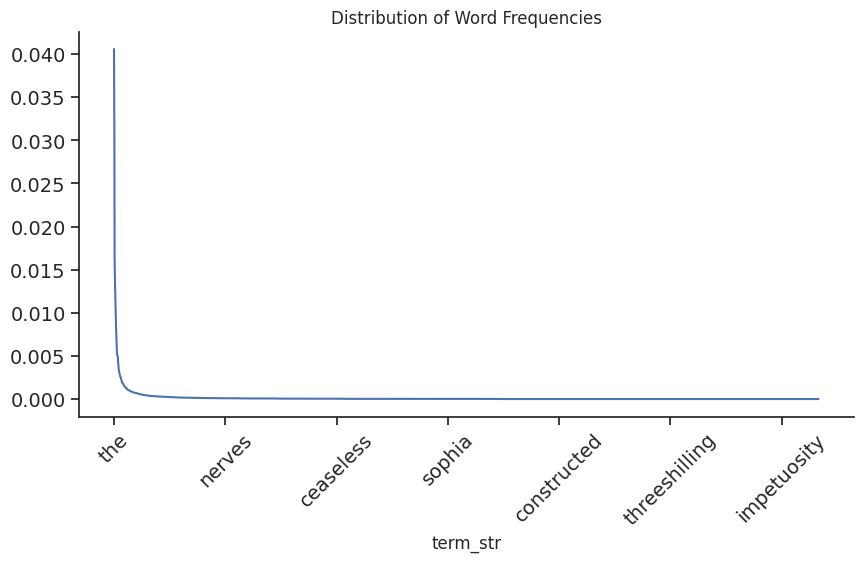

In [33]:
VOCAB.p.plot(figsize=(10,5), fontsize=14, rot=45, legend=False, title="Distribution of Word Frequencies")
sns.despine()
plt.show()

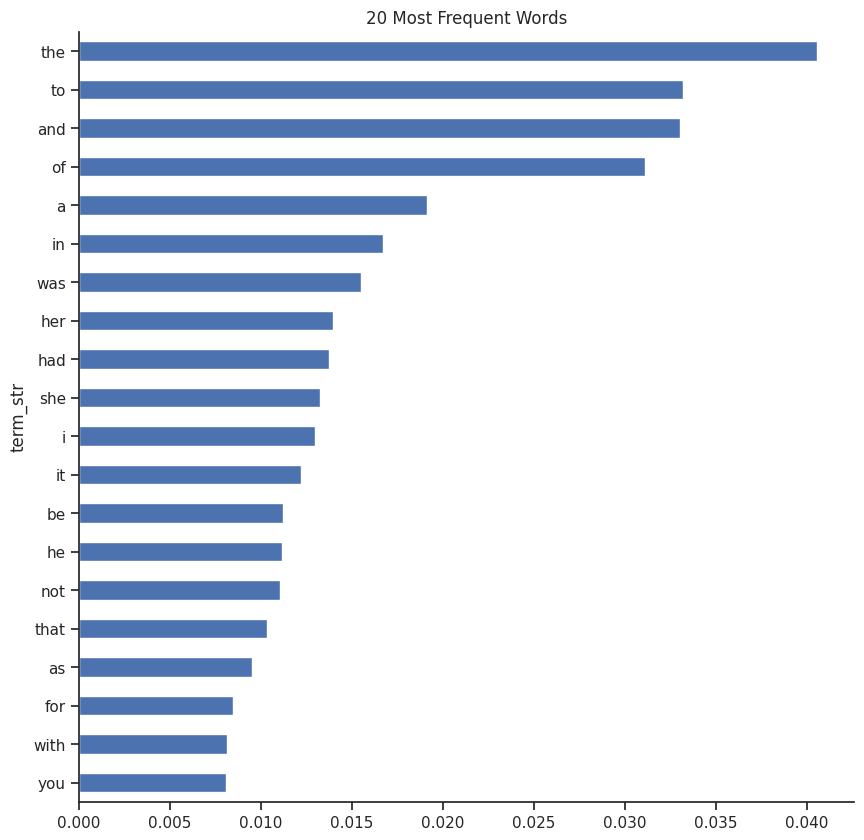

In [34]:
VOCAB.p.head(20).sort_values().plot.barh(figsize=(10,10), title="20 Most Frequent Words")
sns.despine()
plt.show()

## Save Work

We save our work to use in later notebooks.

In [35]:
TOKEN.to_csv(f"{output_dir}/M01-ff-TOKENS.csv")
VOCAB.to_csv(f"{output_dir}/M01-ff-VOCAB.csv")

## Aside: The The

Why is "the" the most frequent word?

Consider that "the" is "[The Most Powerful Word in the English Language](http://www.bbc.com/culture/story/20200109-is-this-the-most-powerful-word-in-the-english-language)."

> ... ‘the’ lies at the heart of English grammar, having a function rather than a meaning. Words are split into two categories: expressions with a semantic meaning and functional words like ‘the’, ‘to’, ‘for’, with a job to do. ‘The’ can function in multiple ways. This is typical, explains Gary Thoms, assistant professor in linguistics at New York University: “a super high-usage word will often develop a real flexibility”, with different subtle uses that make it hard to define. Helping us understand what is being referred to, ‘the’ makes sense of nouns as a subject or an object. So even someone with a rudimentary grasp of English can tell the difference between ‘I ate an apple’ and ‘I ate the apple’.

Note: function vs. meaning ...

> **Function words are very specific to each language.**<br/><br/>
So, someone who is a native Hindi or Russian speaker is going to have to think very differently when constructing a sentence in English. Murphy says that she has noticed, for instance, that sometimes her Chinese students hedge their bets and include ‘the’ where it is not required. Conversely, Smith describes Russian friends who are so unsure when to use ‘the’ that they sometimes leave a little pause: ‘I went into... bank. I picked up... pen.’ English speakers learning a language with no equivalent of ‘the’ also struggle and might overcompensate by using words like ‘this’ and ‘that’ instead.